Импортируем все необхожимые модули для работы с данными и графиками

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score as r2

label = LabelEncoder()

Считываем тестовые данные из файла test.csv

In [3]:
data = pd.read_csv('./data/train.csv')

Просмотрим информацию по данным

In [4]:
data.shape

(10000, 20)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


У признаков LifeSquare и Healthcare_1 есть пустые значения, а признаки Ecology_2, Ecology_3 и Shops_2 - содержат строковые данные.

In [6]:
data.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
data.Ecology_2.head(3)

0    B
1    B
2    B
Name: Ecology_2, dtype: object

In [8]:
data.Ecology_3.head(3)

0    B
1    B
2    B
Name: Ecology_3, dtype: object

In [9]:
data.Shops_2.head(3)

0    B
1    B
2    B
Name: Shops_2, dtype: object

### Графики

Для того, чтобы просмотреть какие кризначки влияют на ценообразование, построим грацики по каждому из них в разрезе цены.

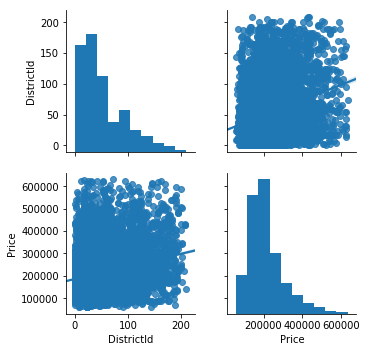

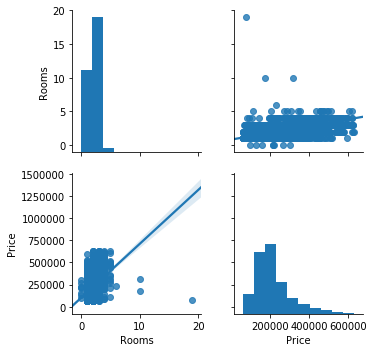

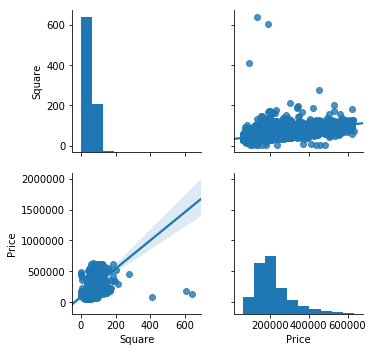

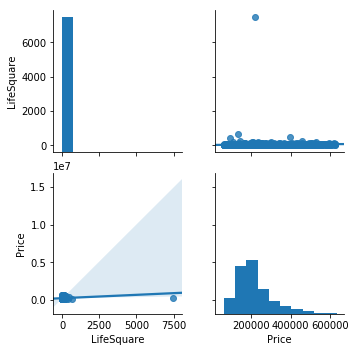

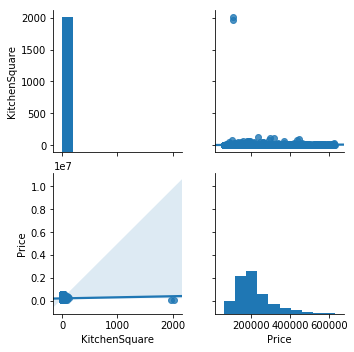

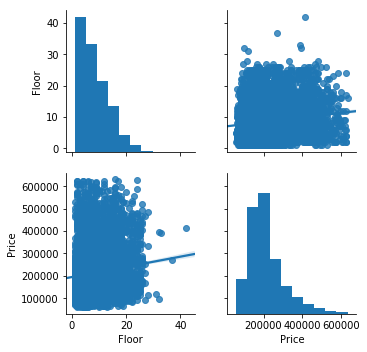

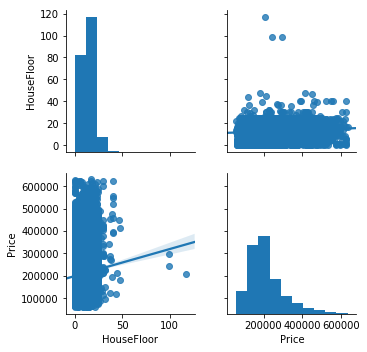

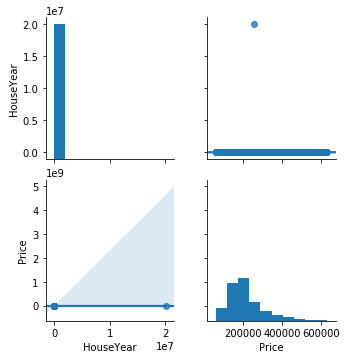

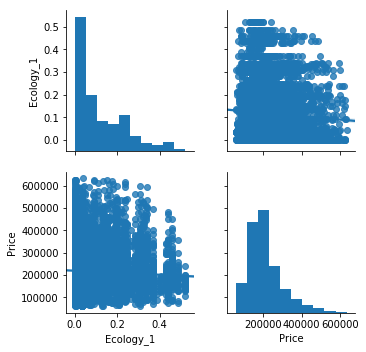

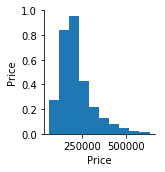

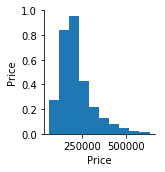

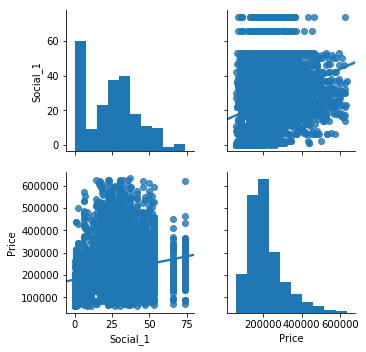

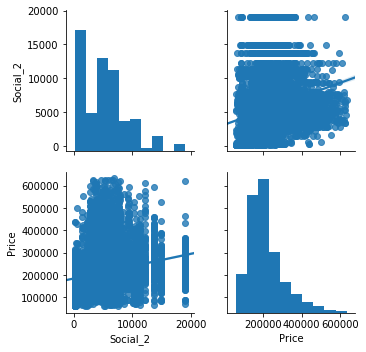

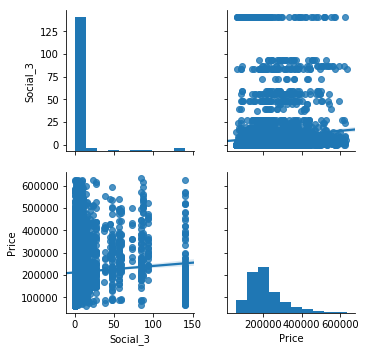

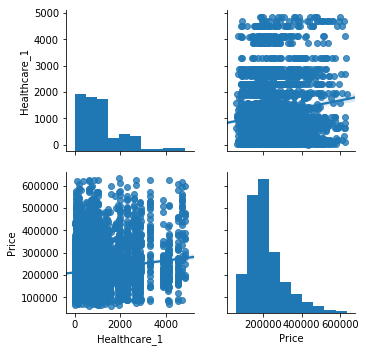

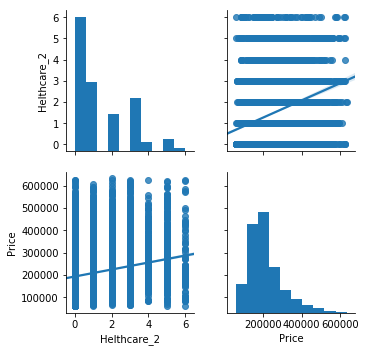

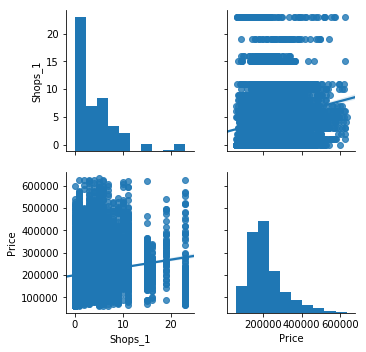

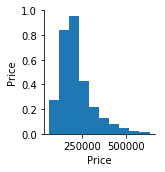

In [10]:
columns_len = len(data.columns)
columns = data.columns[1:columns_len - 1]

for column in columns:
    sns.pairplot(data.loc[:, [column, 'Price']], 
            kind='reg', 
            diag_kind='hist')

Как видно из графиков, есть признаки **DistrictId, Rooms, Square, LifeSquare, HouseYear, KitchenSquare, Floor, HouseFloor, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1** влияют на ценообразование. Так же вижно, что значения некотрых признаков выбиваются из общей массы. Например, **HouseYear**. Потому нужно будет произвести очистку данных.

### Очистка данных

Для того, чтобы понять, что не так с признаком **HouseYear**, отсортируем данные по этому признаку и просмотрим значения.

In [11]:
data.HouseYear.sort_values().tail(5)

7076        2020
5701        2020
1499        2020
4189        4968
1497    20052011
Name: HouseYear, dtype: int64

Как видно из данных, есть значения **4968, 20052011**, которые были ошибочно введены.
Пройдемся по всем категориям, в которых есть вбросы неправильных данных: **HouseYear, Healthcare_1, Rooms, Square, LifeSquare, HouseFloor**.

In [12]:
mean_year = np.round(data.loc[data['HouseYear'] <= 2020, 'HouseYear'].mean())

In [13]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [14]:
def clean_healthcare(df):
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].mean()*0.85

In [15]:
def clean_rooms(df):
    df.loc[(df['Rooms'] > 6), 'Rooms'] = df[(data.Rooms < 7)].Rooms.max()

In [16]:
def clean_square(df):
    df.loc[(df['Square'] > 250), 'Square'] = df[(df.Square < 250)].Square.mean()

In [17]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()) | (df['LifeSquare'] > 2500),
           'LifeSquare'] = df[df['LifeSquare'] < 2500].LifeSquare.max()

In [18]:
def clean_house_floor(df):
    df.loc[(df['HouseFloor'].isnull()) | (df['HouseFloor'] > 60),
           'HouseFloor'] = df[(df.HouseFloor < 60)].HouseFloor.mean()

Как было видно выше признаки **Ecology_2, Ecology_3, Shops_2** содержат в себе строки. Надо перевести их в цифры, чтобы обучить модель более верно. для этого применим **LabelEncoder** из модуля **sklearn.preprocessing**.

In [19]:
def convert_object_to_int(df, column_name):
    dicts = {}
    label.fit(df[column_name].drop_duplicates()) #задаем список значений для кодирования
    dicts[column_name] = list(label.classes_)
    df[column_name] = label.transform(df[column_name])

In [20]:
def prepare_data(df, mean_year=mean_year):
    clean_year(df, mean_year)
    clean_healthcare(df)
    clean_rooms(df)
    clean_square(df)    
    clean_life_square(df)
    clean_house_floor(df)
    convert_object_to_int(df, 'Ecology_2')
    convert_object_to_int(df, 'Ecology_3')
    convert_object_to_int(df, 'Shops_2')

### Обучение модели

Для обучения модели применяется метод **train_test_split** из модуля **sklearn.model_selection**.

In [21]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

Убедимся, что данные для обучения были разбиты верно, как было задано в настройках.

In [22]:
train.shape

(7000, 20)

In [23]:
valid.shape

(3000, 20)

Вызовим очистку данных для каждого набора данных

In [24]:
prepare_data(train)
prepare_data(valid)

Вычислим среднюю цену в разрезе района и количества комнат.

Вычислим среднюю цену в разрезе количества комнат.

Добавим шума в данные, чтобы уменьшить переобучение модели

In [25]:
np.random.seed(42)

In [26]:
noise = 5000*np.random.randn(train.shape[0]) * (train['Rooms'] + 1)

In [27]:
train['Price_n'] = train['Price'] + noise

In [28]:
mean_price = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price_n']].mean().\
    rename(columns={'Price_n':'mean_price'})
mean_price.head()

,DistrictId,Rooms,mean_price
0,0,1.0,139085.130239
1,0,2.0,192533.321516
2,0,3.0,283993.875029
3,1,1.0,147209.801981
4,1,2.0,197615.939911


In [29]:
mean_price2 = train.groupby('Rooms', as_index=False)[['Price_n']].mean().\
    rename(columns={'Price_n':'mean_price2'})

In [30]:
mean_price2

,Rooms,mean_price2
0,0.0,184698.447550
1,1.0,160015.854986
2,2.0,214812.664313
3,3.0,291766.759032
4,4.0,385431.669473
5,5.0,393137.231599
6,6.0,196367.377617


Вычислим среднюю цену по всем признакам.

In [31]:
mean_price_all = train['Price_n'].mean()
mean_price_all

214421.1359664759

In [32]:
def add_mean_price(df, mean_price=mean_price, mean_price2=mean_price2):
    global mean_price_all
    df = pd.merge(df, mean_price2, on='Rooms', how='left')
    df['mean_price2'] = df['mean_price2'].fillna(mean_price_all)
    df = pd.merge(df, mean_price, on=['DistrictId', 'Rooms'], how='left')
    df['mean_price'] = df['mean_price'].fillna(df['mean_price2'])
    df = df.drop('mean_price2', axis=1)
    return df

Добавим средние цены в тренировочный набор данных и просмотрим результат.

In [33]:
train = add_mean_price(train)

In [34]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_n,mean_price
0,14604,23,1.0,41.681380,22.796166,8.0,14,17.0,2015.0,0.075779,...,6,1437,3,963.794742,0,2,1,88504.384965,93471.526495,102127.194313
1,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977.0,0.014073,...,2,475,0,963.794742,0,0,1,207007.956663,204242.670639,171871.557412
2,235,87,1.0,39.710131,19.538663,8.0,4,17.0,1986.0,0.100456,...,43,7227,0,963.794742,1,6,0,182126.280899,188603.166280,171991.933871
3,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017.0,0.041125,...,46,9515,5,963.794742,1,10,1,524365.550705,554826.147834,385852.544243
4,10773,77,3.0,79.195825,44.421062,10.0,16,17.0,1984.0,0.298205,...,16,4048,3,963.794742,1,3,1,322048.433990,317365.366496,256849.158485


Проделаем ту же самую операцию для валидационный набора данных

In [35]:
valid = add_mean_price(valid)

##### Настройка и обучение модели.

Если ответ количественный, то задача называется задачей восстановления регрессии. Если ответ категориальный, то задача называется задачей классификации. В нашем случае надо предсказать цену квартир по признакам. Потому надо применить регрессию.

In [36]:
model = LR()

Просмотрим колонки, которые присутствуют в данных.

In [37]:
data.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

Создадим список признаков, по которым мы будем обучать модель. Как было видно выше, эти признаки мы получили из диаграм. Мы определили их, как признаки, влияющие на ценообразование.

In [38]:
feats = ['DistrictId', 'Rooms', 'Square', 'LifeSquare',
         'HouseYear', 'KitchenSquare', 'Floor',
         'HouseFloor', 'Social_1', 'Social_2',
         'Social_3', 'Healthcare_1', 'Helthcare_2',
         'Shops_1', 'mean_price']

Обучим модель и просмотрим R^2 для каждго набора данных

In [39]:
model.fit(train.loc[:, feats], train['Price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
y_pred_train = model.predict(train.loc[:, feats])

In [41]:
y_pred_train

array([113222.42697723, 316419.19311875, 179349.06990042, ...,
       252703.87509086, 202434.13941527, 313206.70142839])

In [42]:
from sklearn.metrics import r2_score as r2

In [43]:
r2(train['Price'], y_pred_train)

0.7300479004124141

In [44]:
y_pred_valid = model.predict(valid.loc[:, feats])

In [45]:
r2(valid['Price'], y_pred_valid)

0.6092369261922336

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [47]:
def evaluate_model(model, train, valid, metric, feats, target, max_depth):
    dtr = model(max_depth=max_depth)
    dtr.fit(train.loc[:, feats], train[target])
    y_pred_train = dtr.predict(train.loc[:, feats])
    y_pred_valid = dtr.predict(valid.loc[:, feats])
    metric_train = metric(train[target], y_pred_train)
    metric_valid = metric(valid[target], y_pred_valid)
    return metric_train, metric_valid

In [48]:
def check_param(min_value, max_value, model, train=train, valid=valid, metric=r2, feats=feats, 
                             target='Price'):
    max_depth_arr = []
    metric_train_arr = []
    metric_valid_arr = []

    for i in range(min_value, max_value+1):
        res = evaluate_model(model, train, valid, metric, feats, 
                             target, max_depth=i)
        max_depth_arr.append(i)
        metric_train_arr.append(res[0])
        metric_valid_arr.append(res[1])
    return max_depth_arr, metric_train_arr, metric_valid_arr

In [49]:
max_depth_arr, metric_train_arr, metric_valid_arr = check_param(min_value=1, max_value=14, model=RFR)

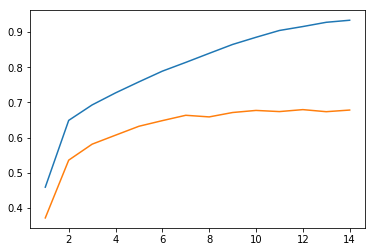

In [50]:
plt.plot(max_depth_arr, metric_train_arr)
plt.plot(max_depth_arr, metric_valid_arr)

In [51]:
np.max(metric_valid_arr)

0.6796748018629779

In [52]:
metric_valid_arr

[0.3720831905706923,
 0.5361592842781876,
 0.5815399235542076,
 0.607097948508529,
 0.6324177565107323,
 0.648412559974849,
 0.6635939549059139,
 0.6589841873726032,
 0.6714701171416886,
 0.6773944620600314,
 0.6741029070635383,
 0.6796748018629779,
 0.6737904585123763,
 0.6784497938252021]

In [53]:
model = RFR(max_depth=12, n_jobs=4, random_state=42)

In [54]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Результирующий тест. Предсказание

In [55]:
test = pd.read_csv('./data/test.csv')

In [56]:
prepare_data(test)

In [57]:
test = add_mean_price(test)

In [58]:
test['Price'] = model.predict(test.loc[:, feats])

In [59]:
test.loc[:, ['Id', 'Price']].to_csv('DChanturiya_predictions.csv', index=None)

In [60]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_price,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972.0,0.310199,...,1,11,2748,1,974.658673,0,0,1,171314.682416,162889.094880
1,15856,74,2.0,69.263183,303.071094,1.0,6,1.0,1977.0,0.075779,...,1,6,1437,3,974.658673,0,2,1,238115.911682,248341.737347
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909.0,0.000000,...,1,30,7538,87,4702.000000,5,5,1,160015.854986,117264.939045
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007.0,0.101872,...,1,23,4583,3,974.658673,3,3,1,202673.102421,301998.732208
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017.0,0.072158,...,1,2,629,1,974.658673,0,0,0,123143.537105,141443.028421
